In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from keras.layers import Dense, SimpleRNN, RNN, LSTM,Dropout,Bidirectional,Attention,Embedding
from keras.optimizers import Adam,SGD,RMSprop,schedules
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
# Config for text vectorizer
# max_features = 5000  # Maximum vocab size.
max_features = 200  # Maximum vocab size. # vocabsize found as 192 see below
max_len = 9  # Sequence length to pad the outputs to.
embedding_dims = 2

In [5]:
# read the text part of the data set
x_train=[]
f = open("hack_txt_ref100.txt", "r")
for l in f:
  x_train.append([l.replace("\n","")])
f.close()

In [6]:
# read the prices of the data set
prices=[]
f = open("hack_price_ref100.txt", "r")
for l in f:
  prices.append([float(l.replace("\n",""))])
f.close()

In [8]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
y_train = scaler.fit_transform(prices)

# our trainings values
x_train

[['CPU10c RAM7 S11 GPU1 13 FHDP Touch Laptop CN'],
 ['CPU10b RAM4 S23 GPU18 Desktop AU'],
 ['CPU10b RAM7 S6 GPU14 17 FHD NonxTouch Laptop FR'],
 ['CPU10b RAM7 S11 GPU1 12 UHD Touch Laptop UK'],
 ['CPU10c RAM10 S25 GPU4 17 FHD NonxTouch Laptop US'],
 ['CPU10b RAM7 S33 GPU1 15 FHD NonxTouch Laptop CN'],
 ['CPU21b RAM14 S68 GPU30 Desktop UK'],
 ['CPU10c RAM14 S23 GPU26 15 FHD NonxTouch Laptop UK'],
 ['CPU8a RAM4 S6 GPU1 14 HDP NonxTouch Laptop FR'],
 ['CPU10c RAM10 S11 GPU21 17 UHD NonxTouch Laptop DE'],
 ['CPU10c RAM10 S45 GPU1 17 UHD NonxTouch Laptop US'],
 ['CPU10c RAM7 S18 GPU4 17 FHD NonxTouch Laptop FR'],
 ['CPU10b RAM7 S23 GPU1 15 HD NonxTouch Laptop BR'],
 ['CPU10c RAM7 S18 GPU14 15 FHD NonxTouch Laptop CN'],
 ['CPU10b RAM7 S11 GPU1 Desktop JP'],
 ['CPU5c RAM7 S17 GPU1 14 FHD NonxTouch Laptop BR'],
 ['CPU8b RAM10 S50 GPU6 Desktop FR'],
 ['CPU11c RAM10 S23 GPU1 Desktop US'],
 ['CPU10b RAM9 S23 GPU14 17 FHD NonxTouch Laptop US'],
 ['CPU10c RAM10 S18 GPU6 15 QHD Touch Laptop DE'],
 [

In [9]:
#Convert the x_train and y_train to numpy arrays, Keras needs it for model.fit 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2752, 1)

In [ ]:
# Create the text vectorization layerlayer.
vectorize_layer = TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

# dapadt builds the vocab for later vectorization
vectorize_layer.adapt(x_train)

In [ ]:
# print the length of the vocab and the vocab, just to see it
print(len(vectorize_layer.get_vocabulary()))
vectorize_layer.get_vocabulary()

In [ ]:
# start to build the model
model = tf.keras.models.Sequential()
# define the input shape
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
#add the text vectorizer
model.add(vectorize_layer)

In [ ]:
# let's see what the vectorizer will do 
model.predict(x_train)

In [ ]:
# that's how the model looks like at the moment
model.summary()

In [ ]:
# add the embdeing layer the intergers will be transformed to in this case 128 element vector
model.add(Embedding(max_features + 1, 128))

In [ ]:
# that's how the model looks like at the moment
# the embeding is trainable, so model.predict does not make sense here
model.summary()

In [ ]:
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(25,activation="relu"))
model.add(Dense(1))

In [ ]:
# that's how the model looks like at the moment
model.summary()

In [ ]:
#Compile the model
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.95)
opt = SGD(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mean_squared_error')

In [ ]:
#Train the model
model_info=model.fit(x_train, y_train, batch_size=4, epochs=100,verbose=1, shuffle=False, validation_split=0.1)
# train for anomaly dection
# model_info=model.fit(x_train, y_train, batch_size=4, epochs=500,verbose=1, shuffle=True)

In [ ]:
pred_price = model.predict([['CPU5b RAM4 S23 GPU1 13 FHD Non-Touch IN']])
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

In [10]:
pred_prices=model.predict(x_train)
pred_prices = scaler.inverse_transform(pred_prices)
#pred_prices

In [11]:
price_err=100*((pred_prices-prices)/prices)

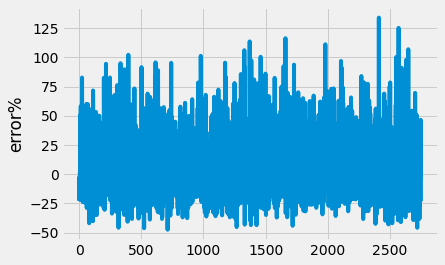

In [12]:

plt.plot(price_err[:,0])
plt.ylabel('error%')
plt.show()

In [13]:
c=0
for i in range(len(price_err[:,0])):
    sr=x_train[i][0].split()
#    if(abs(price_err[i][0])>100 and sr[3]=='GPU1'):
    if(abs(price_err[i][0])<5):
#        print(price_err[i][0])
        c=c+1
print(c)

447


In [ ]:
for i in range(len(price_err[:,0])):
    sr=x_train[i][0].split()
#    if(price_err[i][0]>50 and sr[3]=='GPU1'):
    if(price_err[i][0]>100):
        print(sr)
        print(sr[3])
        print(prices[i][0])
        print(pred_prices[i][0])

In [ ]:
for i in range(1):
    percent=(i+1)*100
    t_fnam="hack_txt_ref"+str(percent)+".txt"
    p_fnam="hack_price_ref"+str(percent)+".txt"
    p=open(p_fnam,"w")
    t=open(t_fnam,"w")
    for l in range(len(price_err[:,0])):
        sr=x_train[i][0].split()
        if(not(abs(price_err[l][0])>percent and sr[3])):
            t.write(x_train[l][0])
            t.write("\n")
            p.write(str(prices[l][0]))
            p.write("\n")
t.close()
p.close()


In [ ]:
price_err[0,0]


In [ ]:
model.save("hack_model/lstm_20201203_first")

## Test Data prediction


In [2]:
model=keras.models.load_model('hack_model/lstm_20201203_first')

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 9)                 0         
_________________________________________________________________
embedding (Embedding)        (None, 9, 128)            25728     
_________________________________________________________________
lstm (LSTM)                  (None, 50)                35800     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1

In [15]:
# read the text part of the data set
x_test=[]
f = open("hack_test1a.txt", "r")
for l in f:
  x_test.append([l.replace("\n","")])
f.close()

In [16]:
test_prices=model.predict(x_test)

In [17]:
test_prices = scaler.inverse_transform(test_prices)

In [19]:
test_prices

array([[1064.3439 ],
       [1102.0242 ],
       [1106.5336 ],
       [1167.8698 ],
       [1107.8822 ],
       [1119.8917 ],
       [1010.3017 ],
       [ 975.0646 ],
       [ 938.2713 ],
       [ 973.813  ],
       [1025.3983 ],
       [ 971.90314],
       [1007.3691 ],
       [1051.877  ],
       [1009.0519 ],
       [1004.98004],
       [ 936.0712 ],
       [1043.9082 ],
       [ 994.4045 ],
       [1090.0242 ],
       [1041.2732 ],
       [1062.2881 ],
       [1075.7882 ],
       [ 986.22186],
       [1025.5582 ],
       [1045.1831 ],
       [1041.2867 ],
       [1041.8124 ],
       [ 991.23987],
       [1005.6702 ],
       [1021.74506],
       [1473.2543 ],
       [1054.6321 ],
       [1018.57544],
       [1043.8625 ],
       [1117.7289 ],
       [1488.8351 ],
       [1233.5271 ],
       [1156.5239 ],
       [1142.7047 ],
       [1205.3612 ],
       [1252.7769 ],
       [1255.4281 ],
       [1429.8256 ],
       [1569.3829 ],
       [1610.0651 ],
       [2046.4209 ],
       [1666.

In [21]:
f=open("hack_test_prices.txt","w")
for l in range(len(test_prices[:,0])):
    f.write(str(test_prices[l][0]))
    f.write("\n")
    
f.close()